In [1]:
from datetime import datetime, timedelta
from pprint import pprint

import numpy as np
import pandas as pd
import utils as ut

# Data Exploration OEF Switzerland

The daily forecasts can be queried using the webservice.

## Data Retrieval and Exploration

### Projects
First get the `Projects` and look at their metadata.

In [2]:
# set the path to the webservice
url = 'http://ramsis-rise.ethz.ch:8000/v1'

projects = ut.get_data(url, '/projects')

print('Projects in the database:')
for p in projects:
    dt = datetime.strptime(p["creationinfo"]["creationtime"], '%Y-%m-%dT%H:%M:%S.%f')
    print(f'Project {p["id"]}: called "{p["name"]}" with description "{p["description"]}" '
          f'which was created on the "{datetime.strftime(dt, "%-d %b %y")}" at "{datetime.strftime(dt, "%H:%M")}".')


Projects in the database:
Project 1: called "Operational Earthquake Forecasting" with description "Operational Earthquake Forecasting, 1992 catalog starttime,  mc=1.75" which was created on the "6 Jun 23" at "08:21".


Now let's take the "ETAS OEF Project" with ID 1 and look at the `ForecastSeries` created in this `Project`.

In [3]:
oef_project = projects[0]
forecastseries = [ut.get_data(url, f'/forecastseries/{s}') for s in oef_project['forecastseries']]
print(f'Forecastseries in project {oef_project["id"]}:')
for s in forecastseries:
    print(f'Forecastseries {s["id"]}: called "{s["name"]}" running from "{s["starttime"]}" until "{s["endtime"] if "endtime" in s else "no endtime"}" every {s["forecastinterval"]/60/60} hours.')

Forecastseries in project 1:
Forecastseries 1: called "OEF Switzerland test schedule" running from "2023-05-25T05:00:00" until "no endtime" every 24.0 hours.


### ForecastSeries
Each `ForecastSeries` executes `Forecasts` in the scheduled interval, in this case each day. The ID's of the respective `Forecasts` can be accessed via the forecast key. Get the newest `Forecast` and look at its metadata.

In [4]:
ut.get_data(url, f'/forecasts/{sorted(forecastseries[0]["forecasts"])[-1]}')

{'id': 15,
 'creationinfo': {'creationtime': '2023-06-08T05:00:01.295786'},
 'starttime': '2023-06-08T05:00:00',
 'endtime': '2024-06-07T05:00:00',
 'runs': [29, 30],
 'status': 'COMPLETE'}

We would now like to access the `Forecast` of a specific day, let's request all `Forecasts` belonging to the same `ForecastSeries` and find the one which starts on the 3rd of May 2023.

In [24]:
# request forecasts belonging to forecastseries
forecast = ut.get_data(url, f'/forecastseries/{forecastseries[0]["id"]}/forecasts')
# find the forecast starting on the 2nd of June 2023
forecast = next(f for f in forecast if datetime.strptime(f['starttime'], '%Y-%m-%dT%H:%M:%S').date() == datetime(2023, 6, 2).date())
forecast

{'id': 9,
 'creationinfo': {'creationtime': '2023-06-06T09:15:07.327606'},
 'starttime': '2023-06-02T05:00:00',
 'endtime': '2024-06-01T05:00:00',
 'runs': [17, 18],
 'status': 'COMPLETE'}

Here events from `starttime` until `endtime` are forecasted. There were two actual calculations executed (`runs`/`ModelRuns`), each with a different configuration of the same model.  
Looking at the first one we can see all the metadata of the `ModelRun` including the configuration parameters passed into the model:

In [25]:
modelrun = ut.get_data(url, f'/modelruns/{forecast["runs"][0]}')
modelrun

{'id': 17,
 'runid': 'c21f8186-7e41-44de-8120-a63a820a98ed',
 'status': 'COMPLETE',
 'modelconfig': {'id': 1,
  'name': 'ETAS model 1992 start mc=2.3 100 simulations',
  'url': 'http://ramsis-nsfm-dev.ethz.ch:5007',
  'sfm_module': 'ramsis_nsfm.models.etas',
  'sfm_class': 'ETASCalculation',
  'config': {'model_parameters': {'mc': 2.3,
    'delta_m': 0.1,
    'theta_0': {'a': 1.13,
     'rho': 0.63,
     'gamma': 0.15,
     'omega': -0.13,
     'log10_c': -2.85,
     'log10_d': -0.51,
     'log10_k0': -2.75,
     'log10_mu': -6.21,
     'log10_tau': 3.57},
    'earth_radius': 6378.1,
    'n_simulations': 100,
    'auxiliary_start': '1992-01-01 00:00:00',
    'timewindow_start': '1997-01-01 00:00:00',
    'coppersmith_multiplier': 100},
   'wrapper_parameters': {}},
  'last_updated': '2023-06-06T08:21:29.174050'},
 'resulttimebins': [24]}

The input catalog used is the same for all `ModelRuns` which belong to the same `Forecast`. It can therefore be accessed using the `/seismiccatalog` endpoint of the respective `Forecast`

In [28]:
input = ut.get_data(url, f'/forecasts/{forecast["id"]}/seismiccatalog')
input['events'][-3:-1]

[{'id': 141357,
  'x': {'value': 7.398325473, 'uncertainty': 0.06673792499},
  'y': {'value': 46.23210144, 'uncertainty': 0.07883316585},
  'z': {'value': -4816.894531, 'uncertainty': 141.129207},
  'magnitude': {'value': 1.944488967, 'uncertainty': 0.2499894962},
  'datetime': {'value': '2023-05-30T23:35:23.257157'}},
 {'id': 141356,
  'x': {'value': 9.558641884, 'uncertainty': 0.1326264897},
  'y': {'value': 47.12218225, 'uncertainty': 0.1156591884},
  'z': {'value': -2353.515625, 'uncertainty': 149.2586929},
  'magnitude': {'value': 1.793795626, 'uncertainty': 0.2662423668},
  'datetime': {'value': '2023-05-31T03:49:01.047104'}}]

### Results
Depending on the model and configuration, the results can now be stored using time and space discretization, here called `ResultTimeBin` and `ResultSpatialBin`. The actual forecasted events can then be stored using their statistics as `SeismicRates`(a, b, rates, mc etc.) or `SeismicForecastCatalogs` (lon, lat, depth, magnitude, time).

For this specific usecase, just one `ResultTimeBin` and one `ResultSpatialBin` are used as the events for all of Switzerland for one Month are forecasted. The results can be retrieved using the /results endpoint of a specific modelrun.

In [29]:
results = ut.get_data(url, f'/modelruns/{forecast["runs"][0]}/results')
print(f'The ModelRun calculated {len(results)} ResultSpatialBin with simulated events from {results[0]["starttime"]} until \n'
      f'{results[0]["endtime"]}. It contains {len(results[0]["spatialbins"])} spatialbins, containing '
      f'{len(results[0]["spatialbins"][0]["catalogs"])} catalogs.')


The ModelRun calculated 1 ResultSpatialBin with simulated events from 2023-06-02T05:00:00 until 
2024-06-01T05:00:00. It contains 1 spatialbins, containing 100 catalogs.


Looking at the forecasted events for this one modelrun, we can see the number of catalogs, which represent probabilistic realizations.

In [30]:
simulations = results[0]["spatialbins"][0]["catalogs"]
print(f'The forecast contains {len(simulations)} catalogs.')
for i in range(2):
    pprint(simulations[i]['events'][0:2])
    pprint('...')

The forecast contains 100 catalogs.
[{'datetime': {'value': '2023-06-02T05:27:08.343123'},
  'id': 290991,
  'magnitude': {'value': 2.4},
  'x': {'value': 10.087209356980303},
  'y': {'value': 46.49045237425042},
  'z': {'value': 0.0}},
 {'datetime': {'value': '2023-07-08T01:16:17.031839'},
  'id': 290992,
  'magnitude': {'value': 2.4},
  'x': {'value': 6.916132011496408},
  'y': {'value': 47.3834062518891},
  'z': {'value': 0.0}}]
'...'
[{'datetime': {'value': '2023-06-02T07:00:48.166002'},
  'id': 291013,
  'magnitude': {'value': 2.5},
  'x': {'value': 6.910525039794006},
  'y': {'value': 47.363953952545685},
  'z': {'value': 0.0}},
 {'datetime': {'value': '2023-08-24T04:36:36.687312'},
  'id': 291014,
  'magnitude': {'value': 3.1},
  'x': {'value': 6.9689737577183335},
  'y': {'value': 45.91545623950774},
  'z': {'value': 0.0}}]
'...'


## Data Processing and Visualization

In order to visualize the data, we first want to transform it into easier-to-use formats and calculate the relevant statistics on it.  

We start by normalizing the json / dict representation into a tabular form.

In [31]:
simulations = ut.normalize_data(results[0]['spatialbins'][0]['catalogs'])
catalog = ut.normalize_data([input])

with pd.option_context('display.expand_frame_repr', False):
    pprint(simulations.head(3))
    pprint(catalog.tail(10))

       id  catalog_id    x_value    y_value  z_value  magnitude_value             datetime_value
0  290991        2315  10.087209  46.490452      0.0              2.4 2023-06-02 05:27:08.343123
1  290992        2315   6.916132  47.383406      0.0              2.4 2023-07-08 01:16:17.031839
2  290993        2315   6.859860  46.332475      0.0              2.5 2023-07-31 22:28:07.130606
          id  catalog_id   x_value  x_uncertainty    y_value  y_uncertainty       z_value  z_uncertainty  magnitude_value  magnitude_uncertainty  magnitude_confidencelevel             datetime_value
6652  141364        1009  9.026365       0.120339  47.030038       0.122867  -5202.636719     304.142384         2.151597               0.235045                        NaN 2023-05-26 05:47:25.742473
6653  141363        1009  9.026487       0.155790  47.032033       0.152974  -4819.335938     384.053758         1.790959               0.287395                        NaN 2023-05-26 06:10:11.659046
6654  141362   

We then also need a couple of parameters for the calculations:

In [32]:
# start time of the forecast
forecast_start = pd.to_datetime(forecast['starttime']).replace(hour=0)

# how long one bin should be in hours in the plotted time series
hour_bins = 24

# mc comes from the forecast config/output.
mc = modelrun['modelconfig']['config']['model_parameters']['mc']

# beta is one of the estimated parameters
beta = 2.422995571846904

# read input file
ch_rect = np.load('ch_rect.npy')

Now lets calculate rates and statistics for the above configured temporal bin sizes.

In [33]:
simulations['bin'] = ut.bin_data(
    forecast_start,
    forecast_start + timedelta(days=30),
    simulations['datetime_value'])

# All events starting from 7 days before the forecast start
catalog['bin'] = \
    ut.bin_data(forecast_start - timedelta(days=7),
                forecast_start, catalog['datetime_value'])

# Frequency dict of events for 7 days leading up to the forecast start
train_data = ut.frequency(
    catalog.query("datetime_value < @forecast_start and magnitude_value >= @mc"))

# Statistics of the forecasted events
forecast_data = ut.frequency_statistics(simulations)


Following the necessary scripts to visualize the forecast.

In [34]:
# move timestamps to midday for centered plotting
for ser in [forecast_data, train_data]:
    ser.index = pd.to_datetime(ser.index).normalize() + pd.Timedelta('12h')

# only display magnitudes from "forecast_start" onwards
stdt = train_data.index[0]
catalog = catalog.query("datetime_value >= @stdt and datetime_value < @forecast_start")

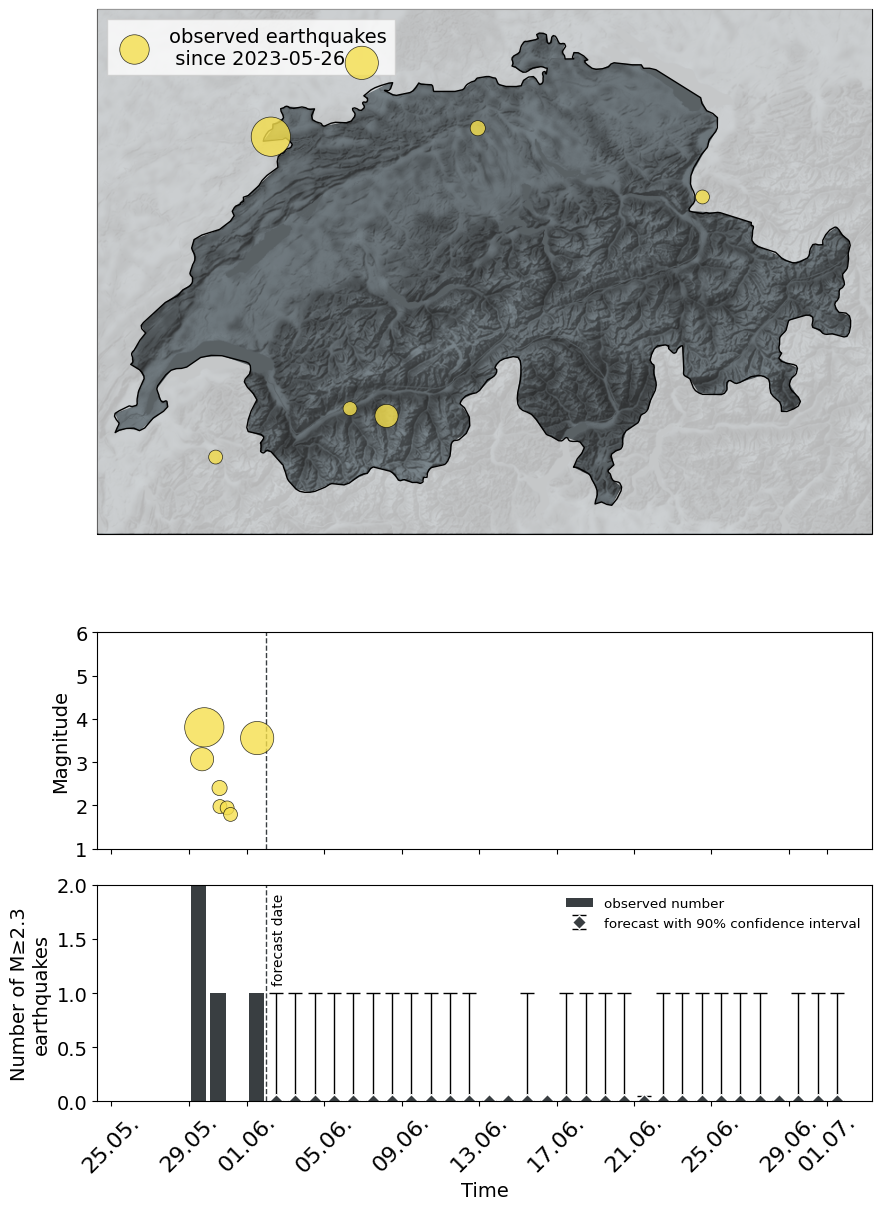

In [35]:
fig = ut.plot_forecast(train_data, forecast_data, catalog, forecast_start, ch_rect)

## Model Comparisons

For each `Forecast` there are two `ModelRuns`, which means that the same input data (catalog) and forecast timespan (startdate and enddate) is used, but the model configuration or the model itself can differ. The idea is, that the results of those `ModelRuns` can be easily compared or combined into ensemble models.

In [36]:
modelrun2 = ut.get_data(url, f'/modelruns/{forecast["runs"][1]}')
modelrun2

{'id': 18,
 'runid': '7db890b9-4415-4087-8b4f-4eb87ddd1dad',
 'status': 'COMPLETE',
 'modelconfig': {'id': 2,
  'name': 'ETAS model 2010-2012 calibration 100 simulations',
  'url': 'http://ramsis-nsfm-dev.ethz.ch:5007',
  'sfm_module': 'ramsis_nsfm.models.etas',
  'sfm_class': 'ETASCalculation',
  'config': {'model_parameters': {'mc': 1.8,
    'delta_m': 0.1,
    'theta_0': {'a': 1.13,
     'rho': 0.63,
     'gamma': 0.15,
     'omega': -0.13,
     'log10_c': -2.85,
     'log10_d': -0.51,
     'log10_k0': -2.75,
     'log10_mu': -6.21,
     'log10_tau': 3.57},
    'earth_radius': 6378.1,
    'n_simulations': 100,
    'auxiliary_start': '2010-01-01 00:00:00',
    'timewindow_start': '2012-01-01 00:00:00',
    'coppersmith_multiplier': 100},
   'wrapper_parameters': {}},
  'last_updated': '2023-06-06T08:21:33.360718'},
 'resulttimebins': [25]}

As we can see above, the parameters are slightly different. The main change is, that the `mc` parameter was lowered to `1.8` while the start of the input catalog was moved up to 2010.  

Now let's request the results from this `ModelRun`. 

In [37]:
results2 = ut.get_data(url, f'/modelruns/{forecast["runs"][1]}/results')
print(f'The ModelRun calculated {len(results)} ResultSpatialBin with simulated events from {results[0]["starttime"]} until \n'
      f'{results[0]["endtime"]}. It contains {len(results[0]["spatialbins"])} spatialbins, containing '
      f'{len(results[0]["spatialbins"][0]["catalogs"])} catalogs.')


The ModelRun calculated 1 ResultSpatialBin with simulated events from 2023-06-02T05:00:00 until 
2024-06-01T05:00:00. It contains 1 spatialbins, containing 100 catalogs.


We can now postprocess the data in the same way as the other `ModelRun`.

In [38]:
simulations2 = ut.normalize_data(results2[0]['spatialbins'][0]['catalogs'])

simulations2['bin'] = ut.bin_data(
    forecast_start,
    forecast_start + timedelta(days=30),
    simulations2['datetime_value'])

# Statistics of the forecasted events
forecast_data2 = ut.frequency_statistics(simulations2)

# move timestamps to midday for centered plotting
forecast_data2.index = pd.to_datetime(forecast_data2.index).normalize() + pd.Timedelta('12h')

# mc comes from the forecast config/output.
mc2 = modelrun2['modelconfig']['config']['model_parameters']['mc']

As mentioned above, the results can be directly compared to each other, let's do that for earthquake probabilities of M≥2.5 and M≥5.0.

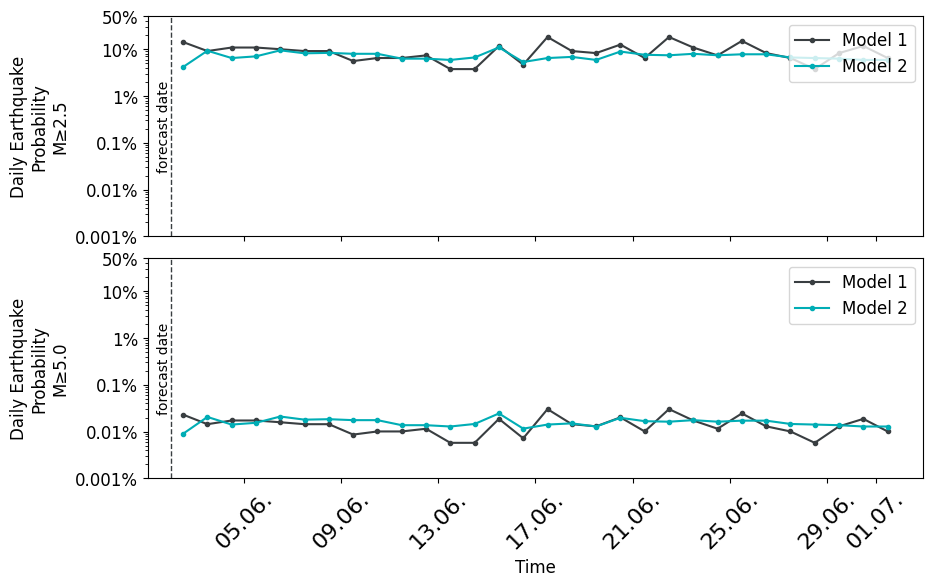

In [39]:
fig2 = ut.plot_probabilities_comparison(forecast_data, mc, forecast_data2, mc2, forecast_start, beta)

## Ensemble Models

Another advantage of the results from the same `Forecast` is, that they can be easily combined into ensemble models. A very simple implementation is done below by averaging the results of the two models.

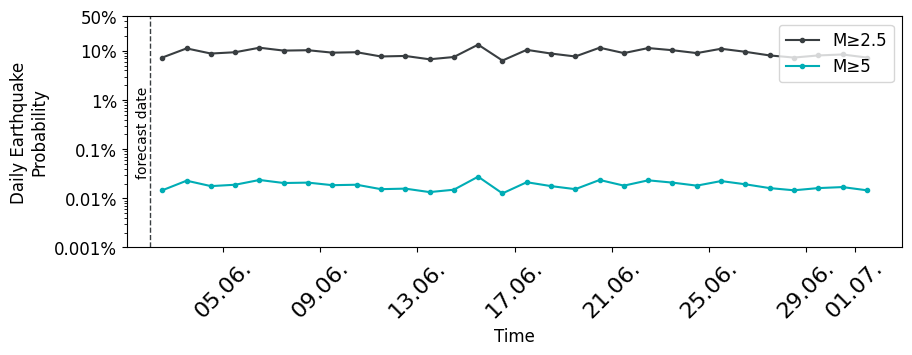

In [40]:
ensemble = pd.concat([forecast_data, forecast_data2], axis=1).groupby(axis=1, level=0).mean()

fig3 = ut.plot_probabilities(ensemble, (mc+mc2)/2, forecast_start, beta)